```
Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# Fine-tune MedSigLIP for image classification

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/medsiglip/blob/main/notebooks/fine_tune_for_multi_label_classification.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogle-Health%2Fmedsiglip%2Fmain%2Fnotebooks%2Ffine_tune_for_multi_label_classification.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/medsiglip/blob/main/notebooks/fine_tune_for_multi_label_classification.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/google/medsiglip-448">
      <img alt="Hugging Face logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on Hugging Face
    </a>
  </td>
</tr></tbody></table>

This notebook demonstrates fine-tuning the MedSigLIP vision encoder for multi-label image
classification using Hugging Face libraries.

## Setup

To complete this tutorial, you'll need to have a runtime with sufficient
resources to fine-tune the MedSigLIP model. **Note:** This guide requires a GPU
that has at least 40 GB of memory.

You can run this notebook in Google Colab using an A100 GPU:

1.  In the upper-right of the Colab window, select **▾ (Additional connection
    options)**.
2.  Select **Change runtime type**.
3.  Under **Hardware accelerator**, select **A100 GPU**.

### Get access to MedSigLIP

Before you get started, make sure that you have access to MedSigLIP models on
Hugging Face:

1.  If you don't already have a Hugging Face account, you can create one for
    free by clicking [here](https://huggingface.co/join).
2.  Head over to the
    [MedSigLIP model page](https://huggingface.co/google/medsiglip-448) and
    accept the usage conditions.

### Configure your HF token

Generate a Hugging Face `write` access token by going to
[settings](https://huggingface.co/settings/tokens). **Note:** Make sure that the
token has write access to push the fine-tuned model to Hugging Face Hub.

If you are using Google Colab, add your access token to the Colab Secrets
manager to securely store it. If not, proceed to run the cell below to
authenticate with Hugging Face.

1.  Open your Google Colab notebook and click on the 🔑 Secrets tab in the left
    panel.
    <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2.  Create a new secret with the name `HF_TOKEN`.
3.  Copy/paste your token key into the Value input box of `HF_TOKEN`.
4.  Toggle the button on the left to allow notebook access to the secret.

In [ ]:
import os
import sys

if "google.colab" in sys.modules and not os.environ.get("VERTEX_PRODUCT"):
    # Use secret if running in Google Colab
    from google.colab import userdata
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
else:
    # Store Hugging Face data under `/content` if running in Colab Enterprise
    if os.environ.get("VERTEX_PRODUCT") == "COLAB_ENTERPRISE":
        os.environ["HF_HOME"] = "/content/hf"
    # Authenticate with Hugging Face
    from huggingface_hub import get_token
    if get_token() is None:
        from huggingface_hub import notebook_login
        notebook_login()

### Install dependencies

In [ ]:
! pip install --upgrade --quiet accelerate datasets evaluate tensorboard transformers

## Prepare fine-tuning dataset

This notebook uses the
[SCIN dataset](https://github.com/google-research-datasets/scin) to fine-tune MedSigLIP to classify the ten most common dermatology conditions:

```
["Eczema", "Allergic Contact Dermatitis", "Insect Bite", "Urticaria", "Psoriasis", "Folliculitis", "Irritant Contact Dermatitis", "Tinea", "Herpes Zoster", "Drug Rash"]
```

**Note:** The SCIN dataset was included in MedSigLIP's training data. It is used as a fine-tuning dataset in this notebook for demonstration purposes.

Download the dataset from
[Cloud Storage](https://console.cloud.google.com/storage/browser/dx-scin-public-data).

In [ ]:
# Skip authentication since this dataset is public
! gcloud config set auth/disable_credentials True && gcloud config set user_output_enabled False

! mkdir dataset
! gcloud storage cp -R gs://dx-scin-public-data/dataset/* dataset/

Load the dataset as a `pandas.DataFrame`.

In [ ]:
import pandas as pd

SCIN_GCS_CASES_CSV = "dataset/scin_cases.csv"
SCIN_GCS_LABELS_CSV = "dataset/scin_labels.csv"


def initialize_df_with_metadata(csv_path: str):
    df = pd.read_csv(csv_path, dtype={"case_id": str})
    df["case_id"] = df["case_id"].astype(str)
    return df


def augment_metadata_with_labels(df: pd.DataFrame, csv_path: str):
    labels_df = pd.read_csv(csv_path, dtype={"case_id": str})
    print(f"Loaded labels with {len(labels_df)} rows.")
    labels_df["case_id"] = labels_df["case_id"].astype(str)
    merged_df = pd.merge(df, labels_df, on="case_id")
    return merged_df


scin_no_label_df = initialize_df_with_metadata(SCIN_GCS_CASES_CSV)
scin_df = augment_metadata_with_labels(scin_no_label_df, SCIN_GCS_LABELS_CSV)
scin_df.set_index("case_id", inplace=True)

scin_df

Loaded labels with 5033 rows.


source release  year     age_group          sex_at_birth  \
case_id                                                                         
-1000600354148496558   SCIN   1.0.0  2023   AGE_UNKNOWN  OTHER_OR_UNSPECIFIED   
-1002039107727665188   SCIN   1.0.0  2023   AGE_UNKNOWN  OTHER_OR_UNSPECIFIED   
-1003358831658393077   SCIN   1.0.0  2023  AGE_18_TO_29                  MALE   
-1003826561155964328   SCIN   1.0.0  2023   AGE_UNKNOWN  OTHER_OR_UNSPECIFIED   
-1003844406100696311   SCIN   1.0.0  2023  AGE_40_TO_49                FEMALE   
...                     ...     ...   ...           ...                   ...   
973759811984683137     SCIN   1.0.0  2023   AGE_UNKNOWN  OTHER_OR_UNSPECIFIED   
973872028150293734     SCIN   1.0.0  2023   AGE_UNKNOWN  OTHER_OR_UNSPECIFIED   
983265958160210646     SCIN   1.0.0  2023  AGE_18_TO_29                FEMALE   
995820220956352730     SCIN   1.0.0  2023   AGE_UNKNOWN  OTHER_OR_UNSPECIFIED   
998890198757718998     SCIN   1.0.0  2023   AGE_UNKNOWN                  MALE   

                     fitzpatrick_skin_type  \
case_id                                      
-1000600354148496558                   NaN   
-1002039107727665188                   NaN   
-1003358831658393077       NONE_IDENTIFIED   
-1003826561155964328                   NaN   
-1003844406100696311                  FST3   
...                                    ...   
973759811984683137                    FST3   
973872028150293734                     NaN   
983265958160210646                    FST5   
995820220956352730                    FST5   
998890198757718998                    FST3   

                     race_ethnicity_american_indian_or_alaska_native  \
case_id                                                                
-1000600354148496558                                             NaN   
-1002039107727665188                                             NaN   
-1003358831658393077                                             NaN   
-1003826561155964328                                             NaN   
-1003844406100696311                                             NaN   
...                                                              ...   
973759811984683137                                               NaN   
973872028150293734                                               NaN   
983265958160210646                                               NaN   
995820220956352730                                               NaN   
998890198757718998                                               YES   

                     race_ethnicity_asian  \
case_id                                     
-1000600354148496558                  NaN   
-1002039107727665188                  NaN   
-1003358831658393077                  NaN   
-1003826561155964328                  NaN   
-1003844406100696311                  NaN   
...                                   ...   
973759811984683137                    NaN   
973872028150293734                    NaN   
983265958160210646                    NaN   
995820220956352730                    NaN   
998890198757718998                    NaN   

                     race_ethnicity_black_or_african_american  \
case_id                                                         
-1000600354148496558                                      NaN   
-1002039107727665188                                      NaN   
-1003358831658393077                                      NaN   
-1003826561155964328                                      NaN   
-1003844406100696311                                      NaN   
...                                                       ...   
973759811984683137                                        NaN   
973872028150293734                                        NaN   
983265958160210646                                        YES   
995820220956352730                                        NaN   
998890198757718998                                        NaN   


Process the DataFrame so that each row corresponds to a training example with an `image` and `label`.

Filter examples with insufficient image quality and
low-confidence labels. Additionally, in the original dataset each data donator contributes up to three images. Make each individual image and its corresponding label into separate examples in the resulting training dataset.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

CONDITIONS = ["Eczema", "Allergic Contact Dermatitis", "Insect Bite", "Urticaria", "Psoriasis", "Folliculitis", "Irritant Contact Dermatitis", "Tinea", "Herpes Zoster", "Drug Rash"]
MINIMUM_CONFIDENCE = 0


def remove_low_confidence_labels(row: pd.Series):
    labels = eval(row.dermatologist_skin_condition_on_label_name)
    confidences = eval(row.dermatologist_skin_condition_confidence)

    row_labels = []
    for label, confidence in zip(labels, confidences):
        if label in CONDITIONS and confidence >= MINIMUM_CONFIDENCE:
            row_labels.append(label)
    return row_labels


# Filter examples with insufficient image quality
scin_df = scin_df[scin_df.dermatologist_gradable_for_skin_condition_1 == "DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT"]

# Remove labels that are below a minimum confidence
scin_df["label"] = scin_df.apply(remove_low_confidence_labels, axis=1)

# Make each image (if it exists) into a separate example.
# Also create a new dataframe with only images and labels.
image_cols = ["image_1_path", "image_2_path", "image_3_path"]
scin_df = pd.melt(
    scin_df, id_vars=["label"], value_vars=image_cols, value_name="image"
).drop(columns=["variable"]).dropna(subset=["image"]).set_index("image")

# Convert labels from e.g. [["Eczema"], ["Urticaria", "Insect Bite"]] to
# [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0, 0, 0, 0]]
mlb = MultiLabelBinarizer(classes=CONDITIONS)
scin_df["label"] = mlb.fit_transform(scin_df["label"]).tolist()

# Drop missing image (https://github.com/google-research-datasets/scin/issues/1)
scin_df.drop(index=["dataset/images/-2243186711511406658.png"], inplace=True)

scin_df

label
image                                                                  
dataset/images/-3205742176803893704.png  [1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
dataset/images/-4762289084741430925.png  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dataset/images/-4027806997035329030.png  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
dataset/images/-3799298995660217860.png  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
dataset/images/-3575683440831198879.png  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
...                                                                 ...
dataset/images/724924647087331057.png    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dataset/images/7906315042206534866.png   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dataset/images/8763368682344373991.png   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dataset/images/6948340611762812997.png   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dataset/images/1619983824061709467.png   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[6451 rows x 1 columns]

Load the DataFrame as a Hugging Face `Dataset` with `from_pandas()`. Then, create train, validation, and test splits.

In [ ]:
from datasets import Dataset, Image

data = Dataset.from_pandas(scin_df)
# Decode image paths as PIL images
data = data.cast_column("image", Image())
data = data.train_test_split(
    test_size=0.2,
    shuffle=True,
    seed=42,
)
validation_test_data = data.pop("test").train_test_split(
    test_size=0.5,
    shuffle=True,
    seed=42,
)
data["validation"] = validation_test_data["train"]
data["test"] = validation_test_data["test"]

# Display dataset details
data

DatasetDict({
    train: Dataset({
        features: ['label', 'image'],
        num_rows: 5160
    })
    validation: Dataset({
        features: ['label', 'image'],
        num_rows: 645
    })
    test: Dataset({
        features: ['label', 'image'],
        num_rows: 646
    })
})

Inspect a sample data point, which contains:

* `image`: dermatology image as a `PIL` image object
* `label`: corresponding multiple labels as a one-hot encoded vector

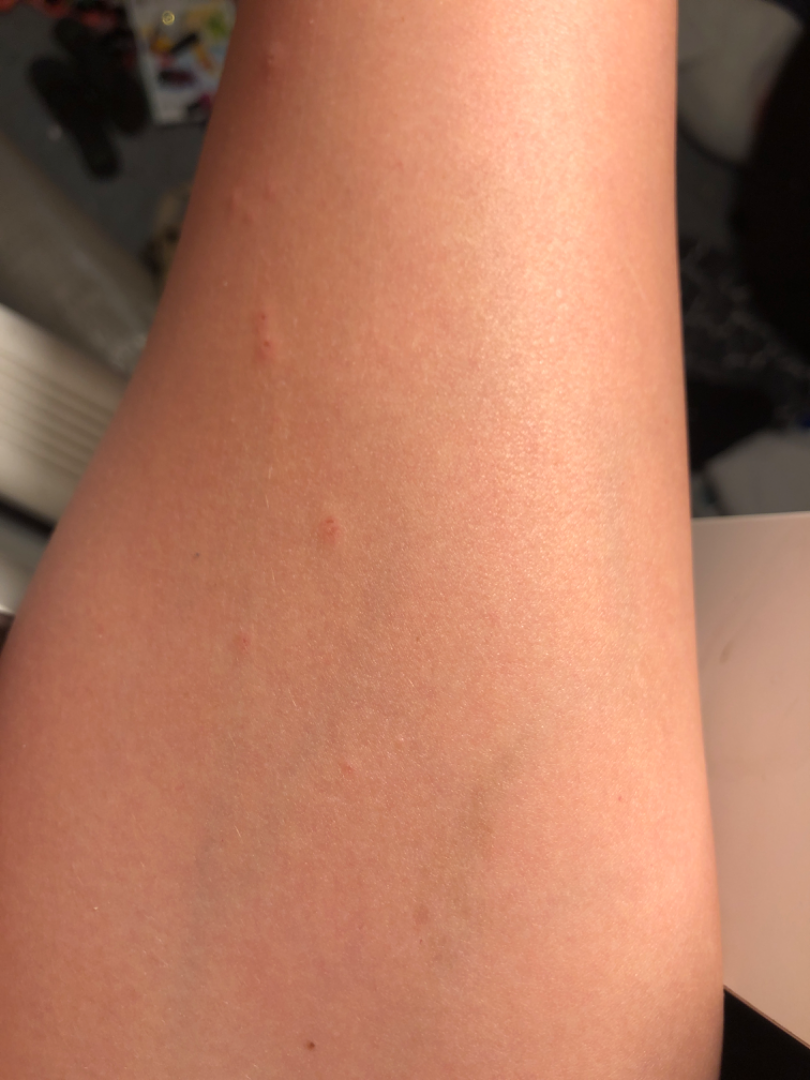

In [ ]:
data["train"][1]["image"]

In [ ]:
data["train"][1]["label"]

[0, 1, 1, 1, 0, 0, 0, 0, 0, 0]

Preprocess the input images.

The model expects the input images to be resized to 448x448 with pixel values rescaled to the range [-1, 1].

Note that the input images are also zero-padded to square before resizing to preserve aspect ratio. This step is included for consistency with the original MedSigLIP training data preprocessing.

In [ ]:
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, Normalize, InterpolationMode
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/medsiglip-448")

size = image_processor.size["height"]  # 448
mean = image_processor.image_mean  # 0.5
std = image_processor.image_std  # 0.5

_transform = Compose([
    Resize((size, size), interpolation=InterpolationMode.BILINEAR),
    # Convert PIL image to PyTorch tensor and rescale pixel values from the
    # range [0, 255] to [0, 1]
    ToTensor(),
    # Scale pixel values to the range [-1, 1]
    Normalize(mean=mean, std=std),
])


def preprocess(examples):
    examples["pixel_values"] = [
        # CenterCrop effectively zero pads the image to a square with size equal
        # to the larger dimension
        _transform(CenterCrop(max(image.size))(image.convert("RGB")))
        for image in examples["image"]
    ]
    return examples


train_data = data["train"].map(preprocess, batched=True, remove_columns=["image"])
validation_data = data["validation"].map(preprocess, batched=True, remove_columns=["image"])

## Fine-tune the model

This notebook demonstrates fine-tuning the MedSigLIP vision encoder for a multi-label image classification task on image and structured label data using the `Trainer` from the Hugging Face `Transformers` library.

Load the MedSigLIP vision encoder with an image classification head on top.

In [ ]:
from transformers import AutoModelForImageClassification

model_id = "google/medsiglip-448"

# Define the label mappings for the classification task
id2label = {i: label for i, label in enumerate(CONDITIONS)}
label2id = {label: i for i, label in enumerate(CONDITIONS)}

model = AutoModelForImageClassification.from_pretrained(
    model_id,
    problem_type="multi_label_classification",
    num_labels=len(CONDITIONS),
    id2label=id2label,
    label2id=label2id,
)

Define a data collator to prepare batches of training examples.

In [ ]:
import torch


def collate_fn(examples):
    pixel_values = torch.tensor([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples], dtype=torch.float)
    return {"pixel_values": pixel_values, "labels": labels}

Define evaluation metrics to be computed during training. The function takes in an [`EvalPrediction`](https://huggingface.co/docs/transformers/en/internal/trainer_utils#transformers.EvalPrediction) which contains the model predictions (logits) and labels.

Similar to MedSigLIP's reported metrics, this example uses the macro-averaged One-vs-rest ROC AUC (Area Under the Receiver Operating Characteristic Curve) score to evaluate multi-class classification performance. See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for more details.

In [ ]:
import evaluate
import numpy as np

roc_auc_score = evaluate.load("roc_auc", "multilabel")


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def metrics_fn(eval_pred):
    logits, labels = eval_pred
    scores = sigmoid(logits)
    return roc_auc_score.compute(
        prediction_scores=scores,
        references=labels,
        average="macro",
        multi_class="ovr",
    )

Define a weighted loss function to address class imbalance within the dataset.

This is the [default loss](https://github.com/huggingface/transformers/blob/cd74917ffc3e8f84e4a886052c5ab32b7ac623cc/src/transformers/models/siglip/modeling_siglip.py#L1205) used for multi-label classification but utilizes `pos_weight` to assign a per-class weight to positive examples, effectively treating minority positive classes with greater importance in the loss calculation. Refer to the [documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) for more details.

**Note:** There are other balancing methods such as oversampling that may be used depending on your dataset and classification task.

In [ ]:
from torch.nn import BCEWithLogitsLoss

labels = torch.tensor(train_data["label"])
num_samples = labels.shape[0]
num_positive = labels.sum(axis=0)
num_negative = num_samples - num_positive
POS_WEIGHT = num_negative / num_positive


def loss_fn(outputs, labels, num_items_in_batch):
    logits = outputs.get("logits")
    pos_weight = POS_WEIGHT.to(logits.device)
    loss_fct = BCEWithLogitsLoss(pos_weight=pos_weight)
    return loss_fct(logits, labels)

Configure training parameters in
[`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments).

In [ ]:
from transformers import TrainingArguments

num_train_epochs = 3  # @param {type: "number"}
learning_rate = 5e-5  # @param {type: "number"}

training_args = TrainingArguments(
    output_dir="medsiglip-448-scin-classification",  # Directory and Hub repository id to save the model to
    num_train_epochs=num_train_epochs,               # Number of training epochs
    per_device_train_batch_size=8,                   # Batch size per device during training
    per_device_eval_batch_size=8,                    # Batch size per device during evaluation
    gradient_accumulation_steps=8,                   # Number of steps before performing a backward/update pass
    logging_steps=40,                                # Number of steps between logs
    save_strategy="epoch",                           # Save checkpoint every epoch
    eval_strategy="steps",                           # Evaluate every `eval_steps`
    eval_steps=40,                                   # Number of steps between evaluations
    learning_rate=learning_rate,                     # Learning rate
    weight_decay=0.01,                               # Weight decay to apply
    warmup_steps=5,                                  # Number of steps for linear warmup from 0 to learning rate
    lr_scheduler_type="cosine",                      # Use cosine learning rate scheduler
    push_to_hub=True,                                # Push model to Hub
    report_to="tensorboard",                         # Report metrics to tensorboard
)

Construct a [`Trainer`](https://huggingface.co/docs/transformers/trainer) using the previously defined training parameters, data collator, metrics function, and weighted loss function.

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    data_collator=collate_fn,
    compute_metrics=metrics_fn,
    compute_loss_func=loss_fn,
)

Launch the fine-tuning process.

**Note:** This may take around 3 hours to run using the default configuration.

In [ ]:
trainer.train()

TrainOutput(global_step=243, training_loss=6.233790099375533, metrics={'train_runtime': 9807.904, 'train_samples_per_second': 1.578, 'train_steps_per_second': 0.025, 'total_flos': 2.3901837313236664e+19, 'train_loss': 6.233790099375533, 'epoch': 3.0})

Save the final model to Hugging Face Hub.

In [ ]:
trainer.save_model()

You can use the link below to navigate to your model repository and click on the "Training metrics" tab to view training curves.

In [ ]:
from huggingface_hub import HfApi

api = HfApi()
username = api.whoami()["name"]
print(f"https://huggingface.co/{username}/{training_args.output_dir}")

## Evaluate the fine-tuned model

### Set up for evaluation

Load the ROC AUC (Area Under the Receiver Operating Characteristic Curve) and additional accuracy metrics to evaluate the model's performance on the classification task.

You can use other accuracy metrics based on your use case and performance requirements.

In [ ]:
from typing import Union

import evaluate
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

roc_auc_score = evaluate.load("roc_auc", "multilabel")

# Ground-truth labels
REFERENCES = data["test"]["label"]


def compute_metrics(
    prediction_scores: np.ndarray,
    threshold: float,
) -> dict[str, float]:
    metrics = {}
    metrics.update(roc_auc_score.compute(
        prediction_scores=prediction_scores,
        references=REFERENCES,
        average="macro",
        multi_class="ovr",
    ))
    predictions = (prediction_scores > threshold).astype(int)
    mcm = multilabel_confusion_matrix(
        y_true=REFERENCES,
        y_pred=predictions,
    )
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    metrics.update({
        "sensitivity": tp / (tp + fn),
        "specificity": tn / (tn + fp),
    })
    return metrics


def print_metrics(metrics: dict[str, Union[float, np.ndarray]]) -> None:
    print(f"Macro-averaged one-vs-rest ROC AUC: {metrics['roc_auc']:.2f}")
    for metric in ["sensitivity", "specificity"]:
        print(f"\n{metric.capitalize()}:")
        for i, condition in enumerate(CONDITIONS):
            print(f"{condition}: {metrics[metric][i]:.4f}")

### Compute metrics on the fine-tuned model

Load the fine-tuned model.

In [ ]:
ft_model = AutoModelForImageClassification.from_pretrained(
    training_args.output_dir,
    problem_type="multi_label_classification",
    num_labels=len(CONDITIONS),
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
)

Run batch inference on the test dataset.

In [ ]:
from PIL import Image
import torch

prediction_scores = []
for batch in data["test"].batch(batch_size=64):
    images = [Image.open(image["path"]) for image in batch["image"]]
    inputs = image_processor(images=images, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = ft_model(**inputs)

    logits = outputs.logits
    scores = torch.sigmoid(logits)
    prediction_scores.extend(scores)

prediction_scores = torch.stack(prediction_scores).cpu().numpy()

Compute metrics.

**Note:** This notebook demonstrates a sample training run and the metrics below have not been optimized. Further tuning will be needed to achieve desired performance.

In [ ]:
# Default threshold used to convert probability scores into class predictions.
# Note that optimal threshold selection is not demonstrated in this notebook.
threshold = 0.5

metrics = compute_metrics(prediction_scores, threshold)
print_metrics(metrics)

Macro-averaged one-vs-rest ROC AUC: 0.85

Sensitivity:
Eczema: 0.7137
Allergic Contact Dermatitis: 0.7005
Insect Bite: 0.6477
Urticaria: 0.6735
Psoriasis: 0.6515
Folliculitis: 0.6491
Irritant Contact Dermatitis: 0.5424
Tinea: 0.5510
Herpes Zoster: 0.5238
Drug Rash: 0.5500

Specificity:
Eczema: 0.6583
Allergic Contact Dermatitis: 0.6906
Insect Bite: 0.8961
Urticaria: 0.9296
Psoriasis: 0.9155
Folliculitis: 0.9083
Irritant Contact Dermatitis: 0.8620
Tinea: 0.9481
Herpes Zoster: 0.9536
Drug Rash: 0.9538


## Next steps

Explore the other [notebooks](https://github.com/google-health/medsiglip/blob/main/notebooks) to learn what else you can do with the model.